In [43]:
import pandas as pd
import numpy as np
import scipy as sp
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

alt.data_transformers.disable_max_rows()
df_train = pd.read_pickle('../data/interim/holdout_lgbm.pck')

df_train.columns

Index(['row_id', 'well_id', 'GR', 'label', 'GR_medfilt', 'label_nn_65',
       'flip_same_65', 'same_after_inv_65', 'label_nn_30', 'flip_same_30',
       ...
       'label_nn_65_lag_30', 'label_nn_65_lag_35', 'label_nn_65_lag_40',
       'label_nn_65_lag_45', 'label_0', 'label_1', 'label_2', 'label_3',
       'label_4', 'pred'],
      dtype='object', length=183)

/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


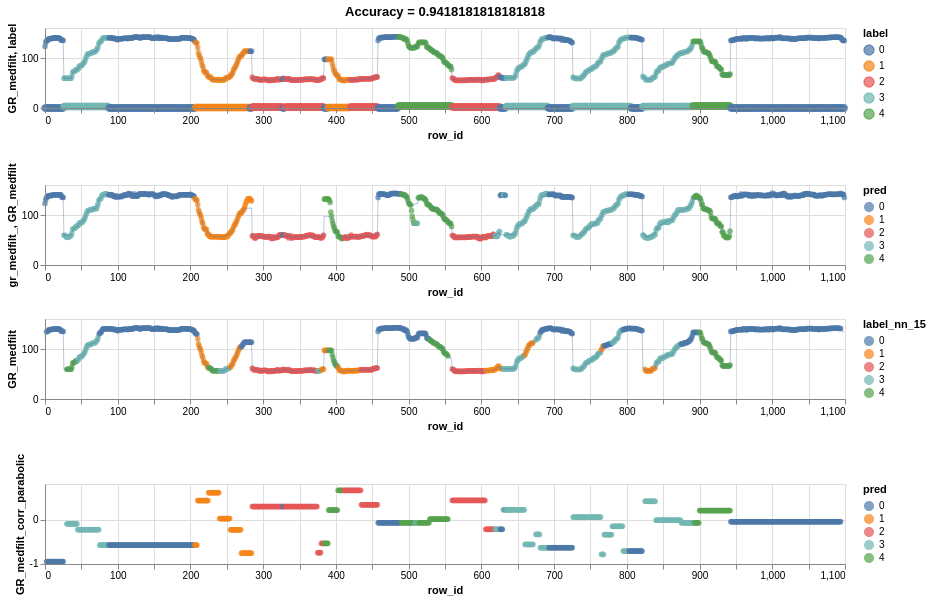

In [72]:
from sklearn.metrics import accuracy_score
from scipy.signal import medfilt
#well_ids = 80
well_ids = 68
#well_ids = 85 # s6ides
#well_ids  = np.random.randint(0,100,1)[0]
#well_ids = 50


df_sub = df_train[df_train['well_id'] == well_ids]

cols = ['GR_medfilt','row_id','well_id','label','pred','label_nn_15','GR_medfilt_corr_parabolic','GR','gr_medfilt_']
df_sub['gr_medfilt_'] = medfilt(df_sub['GR'],11)
sc = accuracy_score(df_sub['label'],df_sub['pred'])
title= f'Accuracy = {sc}'
ch_gr = alt.Chart(df_sub[cols],height=80,width=800,title=title).encode(x='row_id',y='GR_medfilt',order='row_id',color='label:N').mark_point(size=30,filled=True)
ch_lab = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='label',order='row_id',color='label:N').mark_point()
ch_grp = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='gr_medfilt_',order='row_id',color='pred:N').mark_point(size=30,filled=True)
ch_grp_nn = alt.Chart(df_sub[cols].dropna(),height=80,width=800).encode(x='row_id',y='GR_medfilt',order='row_id',color='label_nn_15:N').mark_point(size=30,filled=True)

ch_grp_l = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='GR_medfilt',order='row_id').mark_line(size=0.4)
ch_block = alt.Chart(df_sub[cols],height=80,width=800).encode(x='row_id',y='GR_medfilt_corr_parabolic',order='row_id',color='pred:N').mark_point(size=30,filled=True)

((ch_gr + ch_lab+ch_grp_l ) & (ch_grp+ch_grp_l) & (ch_grp_nn+ch_grp_l)  & ch_block  ).resolve_scale(color='independent',y='independent')

In [53]:
scores = []
for w in df_train['well_id'].unique():
    cols = ['GR_medfilt','row_id','well_id','label','pred','label_nn_30','GR_medfilt_corr_parabolic']
    df_sub = df_train[df_train['well_id'] == w][cols].dropna()
    sc = accuracy_score(df_sub['label'],df_sub['pred'])
    scores.append(sc)
scores = np.array(scores)
scores.sort()
(scores> 0.97).sum()

51

(array([ 1.,  0.,  1.,  2.,  1.,  2.,  6.,  6.,  6.,  9.,  9., 14.,  9.,
         8., 17., 21., 12., 16., 16., 10.,  8.,  9.,  8.,  6.,  3.]),
 array([0.85545455, 0.86083636, 0.86621818, 0.8716    , 0.87698182,
        0.88236364, 0.88774545, 0.89312727, 0.89850909, 0.90389091,
        0.90927273, 0.91465455, 0.92003636, 0.92541818, 0.9308    ,
        0.93618182, 0.94156364, 0.94694545, 0.95232727, 0.95770909,
        0.96309091, 0.96847273, 0.97385455, 0.97923636, 0.98461818,
        0.99      ]),
 <a list of 25 Patch objects>)

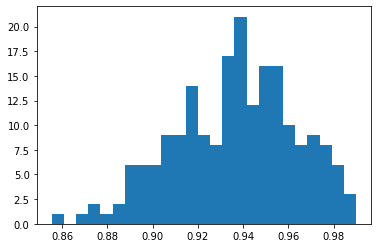

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(scores,bins=25)

# Test UMAP

In [49]:
import umap
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
data = df_train[df_train['well_id']<20].drop(columns=['well_id','label','row_id'])

data = data.fillna(np.nanmean(data))
target =df_train[df_train['well_id']<20]['label']

embedding = make_pipeline(StandardScaler(),umap.UMAP(n_neighbors=45,n_epochs=100)).fit_transform(data,y=target)
#embedding = make_pipeline(StandardScaler(),PCA(2)).fit_transform(data,y=target)


/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pg_model/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/home/anton/miniconda3/envs/pg_model/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 11 separate connected components using meta-embedding (experimental)
  n_components


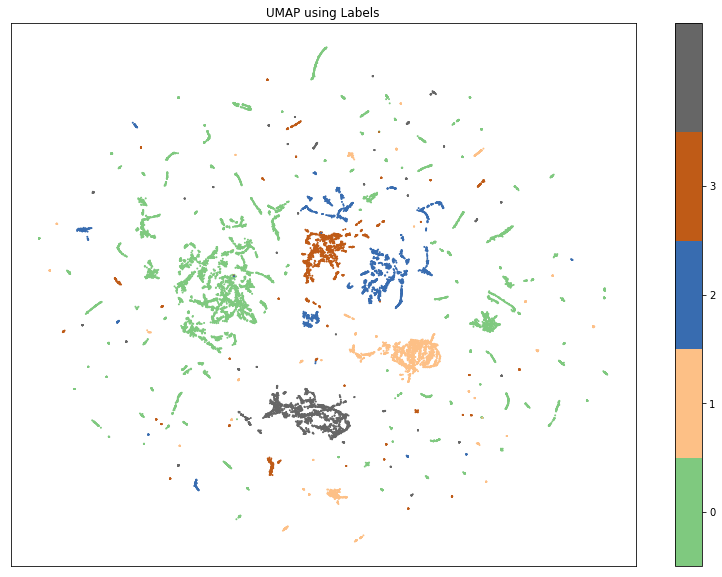

In [50]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.9, c=target, cmap='Accent', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(4))
#cbar.set_ticklabels(classes)
plt.title('UMAP using Labels');

In [ ]:
def make_parabolic(w,amp=50):
    x=[0,w/2,w]
    y=[amp,0,amp]
    p_coef = np.polyfit(x,y,2)
    p=np.poly1d(p_coef)
    x_new = np.arange(w)
    res = p(x_new)
    return res
    
y = make_parabolic(w=50)
tmp = pd.DataFrame({'y':y,'x':np.arange(y.shape[0])})
alt.Chart(tmp).encode(x='x',y='y').mark_point()